COMP-6651 - Algorithm Design Techniques

Project - Clustering Algorithms Analysis

BIRCH Experimentation

Author - Sotirios Damas - 40317602

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (calinski_harabasz_score, silhouette_score,
                             davies_bouldin_score, adjusted_rand_score,
                             normalized_mutual_info_score)
from scipy.spatial.distance import pdist, squareform
import kagglehub

In [ ]:
path_iris = kagglehub.dataset_download("himanshunakrani/iris-dataset")
f_path_iris = os.path.join(path_iris, 'iris.csv')
iris_df = pd.read_csv(f_path_iris)
# Extract labels (species)
iris_labels = iris_df['species']
# Remove label from the features
iris_features = iris_df.drop(columns=['species'])
# Convert to numpy
iris_data = iris_features.values


# Preprocessing for AI Global Index Dataset
def preprocess_ai_index(data):
    # Separate numerical and categorical columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    categorical_cols = data.select_dtypes(exclude=[np.number]).columns

    scaler = MinMaxScaler()
    num_scaled = scaler.fit_transform(data[numeric_cols]) if len(numeric_cols) > 0 else np.array([])

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cat_encoded = encoder.fit_transform(data[categorical_cols]) if len(categorical_cols) > 0 else np.array([])

    if num_scaled.size and cat_encoded.size:
        return np.hstack((num_scaled, cat_encoded))
    elif num_scaled.size:
        return num_scaled
    else:
        return cat_encoded

path_ai_index = kagglehub.dataset_download("katerynameleshenko/ai-index")
f_path_ai_index = os.path.join(path_ai_index, 'AI_index_db.csv')
ai_df = pd.read_csv(f_path_ai_index)
ai_df = ai_df.dropna()
# Extract the 'Cluster' column as the label
ai_labels = ai_df['Cluster']
# Remove the 'Cluster' column from the features
ai_df_features = ai_df.drop(columns=['Cluster'])
# Preprocess the remaining features
ai_data = preprocess_ai_index(ai_df_features)

path_earthquakes= kagglehub.dataset_download("shreyasur965/recent-earthquakes")
f_path_earthquakes = os.path.join(path_earthquakes, 'earthquakes.csv')
earthquake_df = pd.read_csv(f_path_earthquakes)
earthquake_df = earthquake_df[['magnitude', 'felt', 'cdi','mmi','tsunami','sig','depth', 'latitude', 'longitude', 'alert']].dropna()
# Extract the alert labels
earthquake_data_alerts = earthquake_df['alert']
alert_encoded = LabelEncoder().fit_transform(earthquake_data_alerts)
# Remove the label from features
earthquake_data_features = earthquake_df.drop(columns=['alert'])
# Scale the numeric features
earthquake_data = StandardScaler().fit_transform(earthquake_data_features)

100%|██████████| 0.98k/0.98k [00:00<00:00, 1.72MB/s]

Extracting files...


100%|██████████| 2.38k/2.38k [00:00<00:00, 4.44MB/s]

Extracting files...


100%|██████████| 214k/214k [00:00<00:00, 60.8MB/s]

Extracting files...


In [ ]:
def compute_diameter(X, labels):
    """
    Computes the average 'diameter' across all clusters,
    where 'diameter' of a cluster is the maximum distance
    between any two points in that cluster.
    """
    from scipy.spatial.distance import pdist, squareform

    unique_labels = np.unique(labels)
    diameters = []
    for lbl in unique_labels:
        cluster_points = X[labels == lbl]
        if len(cluster_points) > 1:
            # pairwise distances in the cluster
            dist_matrix = squareform(pdist(cluster_points))
            diameters.append(dist_matrix.max())
        else:
            # A single point has diameter 0
            diameters.append(0.0)
    return np.mean(diameters)


def compute_split(X, labels):
    """
    An example 'split' metric: ratio of the size of the largest cluster
    to the size of the smallest cluster. If there's only one cluster, return 1.
    """
    unique_labels, counts = np.unique(labels, return_counts=True)
    if len(counts) < 2:
        return 1.0
    return counts.max() / counts.min()


def evaluate_clustering(X, labels, true_labels=None):
    """
    Compute a set of metrics for the given clustering labels.
    Some metrics require ground truth (true_labels).
    If no true_labels is provided, ARI and MI will be omitted.
    Returns a dict of metric_name -> value.
    """
    metrics_dict = {}

    # Unsupervised metrics
    metrics_dict["Silhouette"] = silhouette_score(X, labels)
    metrics_dict["Davies-Bouldin"] = davies_bouldin_score(X, labels)
    metrics_dict["Calinski-Harabasz"] = calinski_harabasz_score(X, labels)
    metrics_dict["Diameter"] = compute_diameter(X, labels)
    metrics_dict["Split"] = compute_split(X, labels)

    # If we have ground-truth labels, we can compute supervised metrics
    if true_labels is not None:
        metrics_dict["Adjusted Rand Index"] = adjusted_rand_score(true_labels, labels)
        # Using normalized_mutual_info_score as a measure of MI
        metrics_dict["Mutual Information"] = normalized_mutual_info_score(true_labels, labels)

    return metrics_dict


In [ ]:
def agglomerative_clustering_base(X, n_clusters=3, linkage='average'):
    """
    A basic (naïve) implementation of Agglomerative Hierarchical Clustering using average linkage.

    Parameters:
      X : numpy array of shape (n_samples, n_features)
      n_clusters : desired number of final clusters
      linkage : 'average' linkage (only this linkage is implemented here)

    Returns:
      labels : 1D numpy array with final cluster labels for each sample
    """
    n_samples = X.shape[0]
    # Initially, each sample is its own cluster (represented by indices)
    clusters = [[i] for i in range(n_samples)]
    # Compute the initial pairwise distance matrix
    D = squareform(pdist(X, metric='euclidean'))
    np.fill_diagonal(D, np.inf)  # Ignore self-distances

    # While more clusters than desired remain, merge the closest pair
    while len(clusters) > n_clusters:
        min_dist = np.inf
        merge_pair = None

        # Search for the pair with smallest average linkage distance
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                # Average linkage: average distance between all points in cluster i and j.
                distances = [D[a, b] for a in clusters[i] for b in clusters[j]]
                avg_dist = np.mean(distances)
                if avg_dist < min_dist:
                    min_dist = avg_dist
                    merge_pair = (i, j)

        # Merge the chosen pair
        i, j = merge_pair
        new_cluster = clusters[i] + clusters[j]
        # Remove clusters i and j and add the merged cluster.
        # Remove the larger index first to keep indices valid.
        clusters.pop(j)
        clusters.pop(i)
        clusters.append(new_cluster)

    # Create a label array: assign a cluster number to each point.
    labels = np.empty(n_samples, dtype=int)
    for label, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = label
    return labels

In [ ]:
def run_agglomerative_experiment(name, X, n_clusters=3, linkage='average',true_labels=None):
    print(f"----- {name} -----")

    # Base Agglomerative Clustering
    base_labels = agglomerative_clustering_base(X, n_clusters=n_clusters, linkage=linkage)
    base_metrics = evaluate_clustering(X, base_labels, true_labels=true_labels)

    # Sklearn Agglomerative
    sklearn_model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    sklearn_labels = sklearn_model.fit_predict(X)
    sklearn_metrics = evaluate_clustering(X, sklearn_labels, true_labels=true_labels)

    print("Base Agglomerative Clustering Metrics:")
    for k,v in base_metrics.items():
        print(f"  {k}: {v:.4f}")

    print("Sklearn Agglomerative Clustering Metrics:")
    for k,v in sklearn_metrics.items():
        print(f"  {k}: {v:.4f}")

    print("-"*40)
    return base_labels, sklearn_labels


In [ ]:
print("Running Base and Sklearn Agglomerative Clustering on Iris Dataset")
base_labels_iris, sklearn_labels_iris = run_agglomerative_experiment("Iris", iris_data, n_clusters=3, linkage='average', true_labels=iris_labels)

Running Base and Sklearn Agglomerative Clustering on Iris Dataset
----- Iris -----
Base Agglomerative Clustering Metrics:
  Silhouette: 0.5539
  Davies-Bouldin: 0.6588
  Calinski-Harabasz: 555.6662
  Diameter: 2.5208
  Split: 1.7778
  Adjusted Rand Index: 0.7592
  Mutual Information: 0.8057
Sklearn Agglomerative Clustering Metrics:
  Silhouette: 0.5539
  Davies-Bouldin: 0.6588
  Calinski-Harabasz: 555.6662
  Diameter: 2.5208
  Split: 1.7778
  Adjusted Rand Index: 0.7592
  Mutual Information: 0.8057
----------------------------------------


In [ ]:
print("Running Base and Sklearn Agglomerative Clustering on AI Global Index Dataset")
base_labels_ai, sklearn_labels_ai = run_agglomerative_experiment("AI Global Index", ai_data, n_clusters=5, linkage='average', true_labels = ai_labels)

Running Base and Sklearn Agglomerative Clustering on AI Global Index Dataset
----- AI Global Index -----
Base Agglomerative Clustering Metrics:
  Silhouette: 0.1913
  Davies-Bouldin: 1.1991
  Calinski-Harabasz: 6.7301
  Diameter: 1.5839
  Split: 42.0000
  Adjusted Rand Index: 0.0830
  Mutual Information: 0.3798
Sklearn Agglomerative Clustering Metrics:
  Silhouette: 0.1913
  Davies-Bouldin: 1.1991
  Calinski-Harabasz: 6.7301
  Diameter: 1.5839
  Split: 42.0000
  Adjusted Rand Index: 0.0830
  Mutual Information: 0.3798
----------------------------------------


In [ ]:
print("Running Base and Sklearn Agglomerative Clustering on Earthquake Dataset")
base_labels_eq, sklearn_labels_eq = run_agglomerative_experiment("Earthquake", earthquake_data, n_clusters=4, linkage='average',true_labels=alert_encoded)

Running Base and Sklearn Agglomerative Clustering on Earthquake Dataset
----- Earthquake -----
Base Agglomerative Clustering Metrics:
  Silhouette: 0.4676
  Davies-Bouldin: 0.6467
  Calinski-Harabasz: 96.1190
  Diameter: 5.2913
  Split: 732.0000
  Adjusted Rand Index: 0.1686
  Mutual Information: 0.2579
Sklearn Agglomerative Clustering Metrics:
  Silhouette: 0.4676
  Davies-Bouldin: 0.6467
  Calinski-Harabasz: 96.1190
  Diameter: 5.2913
  Split: 732.0000
  Adjusted Rand Index: 0.1686
  Mutual Information: 0.2579
----------------------------------------


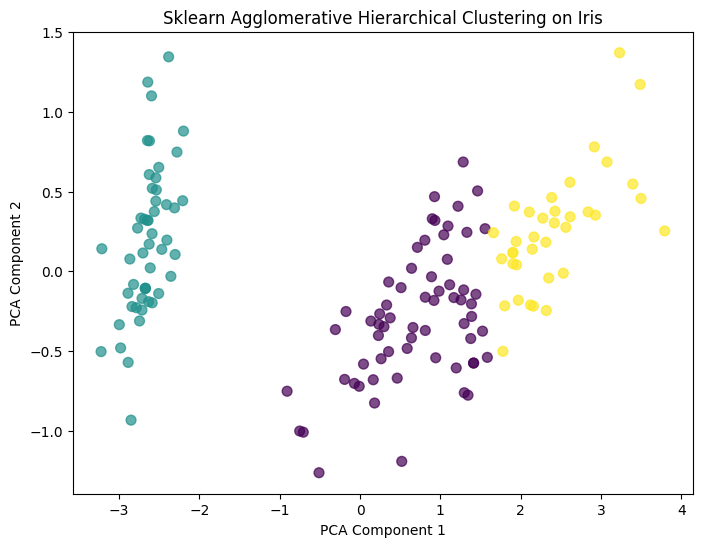

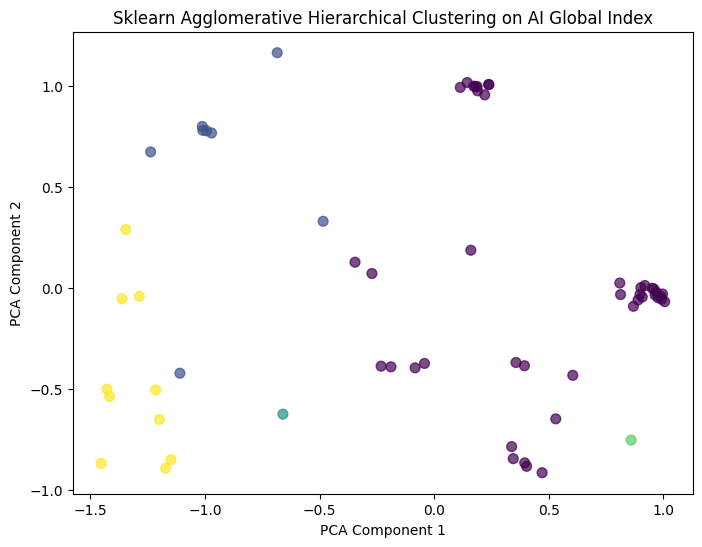

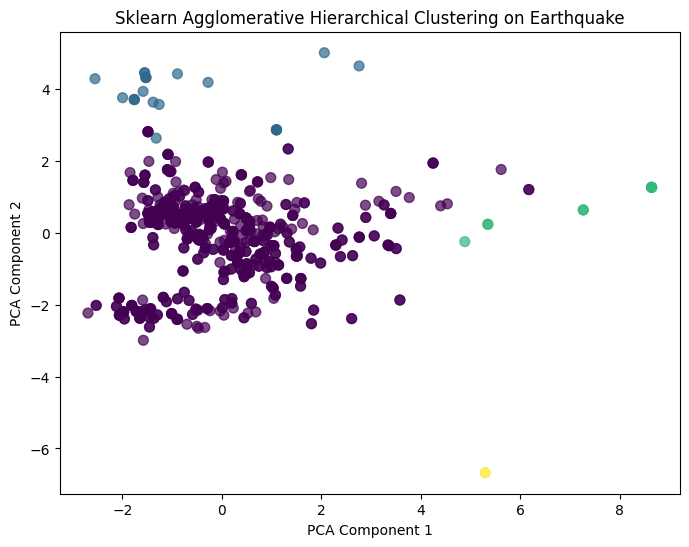

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_clusters(X, labels, title="Cluster Visualization", true_labels=None):
    """
    Reduces data to 2 dimensions using PCA and plots a scatter plot of the clusters.

    Parameters:
      X : array-like, shape (n_samples, n_features)
         The data matrix.
      labels : array-like, shape (n_samples,)
         Cluster labels to color the points.
      title : str
         Title for the plot.
      true_labels : array-like, optional
         True labels for comparison (will create an additional plot).
    """
    # Reduce data to 2 dimensions
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    # Plot clustering result
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    #plt.colorbar(scatter, label="Cluster Label")
    plt.show()

    # If true labels are provided, plot them for comparison
    if true_labels is not None:
        plt.figure(figsize=(8,6))
        scatter_true = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=true_labels, cmap='viridis', s=50, alpha=0.7)
        plt.title(title + " (True Labels)")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.colorbar(scatter_true, label="True Label")
        plt.show()


visualize_clusters(iris_data, sklearn_labels_iris, title="Sklearn Agglomerative Hierarchical Clustering on Iris")

visualize_clusters(ai_data, sklearn_labels_ai, title="Sklearn Agglomerative Hierarchical Clustering on AI Global Index")

visualize_clusters(earthquake_data, sklearn_labels_eq, title="Sklearn Agglomerative Hierarchical Clustering on Earthquake")


In [ ]:
def select_top_k_features_for_alert(df, alert_col='alert', k=5):
    """
    Filters features based on Mutual Information (MI) with the alert label.
    Steps:
      1) Drop rows with any missing values (to avoid errors).
      2) Label-encode the alert column if it is categorical (e.g., text).
      3) For each feature, compute MI against the alert.
      4) Sort features by MI score, descending.
      5) Return the top k feature names.

    """
    data = df.dropna()

    # Separate the target (alert) from the features
    y = data[alert_col]
    X_df = data.drop(columns=[alert_col])

    # encode alert:
    y_enc = LabelEncoder().fit_transform(y)

    # mutual_info_classif calculates MI between each column and y_enc
    mi_scores = mutual_info_classif(X_df.values, y_enc, discrete_features=False)

    # Pair up (feature_name, mi_score)
    feats_and_scores = list(zip(X_df.columns, mi_scores))

    # Sort by MI descending
    feats_and_scores.sort(key=lambda x: x[1], reverse=True)

    # Pick top k
    top_features = [f[0] for f in feats_and_scores[:k]]

    return top_features

## 4.2 - Select the top 5 features for predicting alert

In [ ]:
top5_features = select_top_k_features_for_alert(
    earthquake_df,  # the original DataFrame with 'alert' and other columns
    alert_col='alert',
    k=5
)
print("Top 5 features most predictive of 'alert':", top5_features)

Top 5 features most predictive of 'alert': ['sig', 'mmi', 'longitude', 'latitude', 'magnitude']


## 4.3 - Re-run the clustering using only top-5 features

In [ ]:
# Subset the DataFrame to those top-5 columns
earthquake_df_top5 = earthquake_df[top5_features]

# 2) Scale the new subset
eq_top5_data = StandardScaler().fit_transform(earthquake_df_top5.values)

print("Running Custom/Sklearn Agglomerative Clustering on Earthquake Dataset with Top-5 Features")
_ = run_agglomerative_experiment(
    "Earthquake (Top-5 Features)",
    eq_top5_data,
    n_clusters=4,
    linkage='average',
    true_labels=alert_encoded
)

Running Custom/Sklearn Agglomerative Clustering on Earthquake Dataset with Top-5 Features
----- Earthquake (Top-5 Features) -----
Base Agglomerative Clustering Metrics:
  Silhouette: 0.3630
  Davies-Bouldin: 0.9195
  Calinski-Harabasz: 162.5281
  Diameter: 4.6772
  Split: 122.2000
  Adjusted Rand Index: 0.0400
  Mutual Information: 0.1885
Sklearn Agglomerative Clustering Metrics:
  Silhouette: 0.3630
  Davies-Bouldin: 0.9195
  Calinski-Harabasz: 162.5281
  Diameter: 4.6772
  Split: 122.2000
  Adjusted Rand Index: 0.0400
  Mutual Information: 0.1885
----------------------------------------
